
# Week 8 — Track B: Conversational Data Visualization (Florida — Hurricane Irma)

This Colab-friendly notebook implements a **natural-language → validated plot** pipeline for a small **Hurricane Irma (Florida)** dataset.
- **Input:** NL queries (e.g., “plot wind speed by date”, “show trend for pressure”, “compare rainfall and pressure”)
- **Output:** Safe, validated **matplotlib** plots (no seaborn, no color customization)
- **Mapping:** A rule-based `nl_to_plot_spec()` converts natural-language to a plot specification
- **Dataset:** A small, **embedded** Irma timeline DataFrame (no external files needed)

**Deliverables covered:**
- ≥2 NL queries converted to plots
- Brief notes on **correctness** and **usability**


In [1]:
# [Optional] Uncomment in Colab if needed
!pip install pandas matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ---- Embedded Florida Hurricane Irma (2017) mini-dataset ----
start = datetime(2017, 9, 5)
dates = [start + timedelta(days=i) for i in range(8)]
data = {
    "date": dates,
    "wind_speed": [150, 155, 160, 165, 130, 120, 90, 60],
    "pressure":   [930, 925, 920, 915, 935, 945, 960, 980],
    "rainfall":   [1.2, 2.1, 3.4, 4.8, 7.9, 5.0, 2.3, 0.8],
    "storm_category": [5, 5, 5, 5, 4, 3, None, None],
}
df = pd.DataFrame(data)
df.head()


,date,wind_speed,pressure,rainfall,storm_category
0,2017-09-05,150,930,1.2,5.0
1,2017-09-06,155,925,2.1,5.0
2,2017-09-07,160,920,3.4,5.0
3,2017-09-08,165,915,4.8,5.0
4,2017-09-09,130,935,7.9,4.0



## NL → Plot Specification

We use a **rule-based** mapper that supports:
- metrics: `wind_speed`, `pressure`, `rainfall`, `storm_category`
- x-axis: always `date`
- chart types: `line`, `bar`, `scatter`
- comparisons: `compare X and Y` (renders both on same chart using separate calls; still matplotlib-only)

The mapper **validates** requested fields against an allowlist and raises a friendly error for unsupported fields.


In [8]:
from typing import Dict, List

ALLOWED_COLUMNS = ["date", "wind_speed", "pressure", "rainfall", "storm_category"]
ALLOWED_KINDS = ["line", "bar", "scatter"]

def _pick_metric_from_query(q: str) -> str:
    ql = q.lower()
    if "wind" in ql or "wind_speed" in ql or "windspeed" in ql:
        return "wind_speed"
    if "pressure" in ql:
        return "pressure"
    if "rain" in ql or "rainfall" in ql:
        return "rainfall"
    if "category" in ql or "storm category" in ql:
        return "storm_category"
    return ""

def _pick_second_metric_if_compare(q: str) -> str:
    ql = q.lower()
    metrics = ["wind_speed", "pressure", "rainfall", "storm_category"]
    present = []
    for m in metrics:
        if m in ql or m.replace("_"," ") in ql or (m=="wind_speed" and "wind" in ql):
            present.append(m)
    if len(present) >= 2:
        return present[1]
    base = _pick_metric_from_query(q)
    for m in metrics:
        if m != base and (m in ql or m.replace("_"," ") in ql):
            return m
    return ""

def nl_to_plot_spec(query: str) -> Dict:
    q = query.strip()
    if not q:
        raise ValueError("Empty query")
    ql = q.lower()

    kind = "line"
    if "bar" in ql:
        kind = "bar"
    elif "scatter" in ql:
        kind = "scatter"

    x = "date"
    compare = ("compare" in ql) or ("vs" in ql) or ("versus" in ql)
    y = _pick_metric_from_query(q)
    y2 = _pick_second_metric_if_compare(q) if compare else ""

    if x not in ALLOWED_COLUMNS:
        raise ValueError(f"x='{x}' is not allowed.")
    if not y:
        raise ValueError("Could not detect a metric from your query. Try wind, pressure, rainfall, or category.")
    if y not in ALLOWED_COLUMNS:
        raise ValueError(f"y='{y}' is not allowed.")
    if y2 and y2 not in ALLOWED_COLUMNS:
        raise ValueError(f"y2='{y2}' is not allowed.")
    if kind not in ALLOWED_KINDS:
        raise ValueError(f"kind='{kind}' is not supported. Use one of: {ALLOWED_KINDS}")

    return {"x": x, "y": y, "y2": y2, "kind": kind, "title": query}



## Plot Generator (Matplotlib only)
- Single-series or two-series (for `compare`) plotting
- No seaborn and no color customization


In [7]:
def generate_plot(df: pd.DataFrame, spec: Dict):
    import matplotlib.pyplot as plt
    xcol, ycol, y2col = spec["x"], spec["y"], spec.get("y2", "")
    kind = spec["kind"]
    title = spec.get("title", f"{kind.capitalize()} of {ycol} by {xcol}")

    if xcol not in df.columns or ycol not in df.columns:
        raise ValueError("Requested columns not present in DataFrame.")
    if y2col and y2col not in df.columns:
        raise ValueError("Requested second column not present in DataFrame.")

    fig = plt.figure()
    x = df[xcol]
    y = df[ycol]

    if kind == "line":
        plt.plot(x, y, label=ycol)
        if y2col:
            plt.plot(x, df[y2col], label=y2col)
    elif kind == "bar":
        plt.bar(x, y, label=ycol)
        if y2col:
            import numpy as np
            xi = np.arange(len(x))
            plt.clf()
            fig = plt.figure()
            w = 0.4
            plt.bar(xi - w/2, y, width=w, label=ycol)
            plt.bar(xi + w/2, df[y2col], width=w, label=y2col)
            plt.xticks(xi, [d.strftime("%Y-%m-%d") if hasattr(d, "strftime") else str(d) for d in x], rotation=45)
    elif kind == "scatter":
        plt.scatter(x, y, label=ycol)
        if y2col:
            plt.scatter(x, df[y2col], label=y2col)
    else:
        raise ValueError("Unsupported kind")

    plt.xlabel(xcol)
    plt.ylabel(f"{ycol}" if not y2col else f"{ycol} (+ {y2col})")
    plt.title(title)
    plt.grid(True)
    if y2col:
        plt.legend()
    plt.show()



## Demo: Conversational Queries → Plots
The following cell runs at least two natural-language queries and shows the generated plot and spec.



Query: show wind speed trend over time
Spec: {'x': 'date', 'y': 'wind_speed', 'y2': '', 'kind': 'line', 'title': 'show wind speed trend over time'}


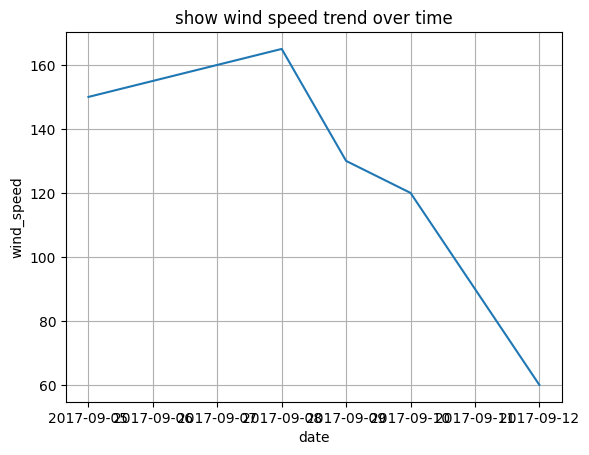


Query: compare rainfall and pressure across days
Spec: {'x': 'date', 'y': 'pressure', 'y2': 'rainfall', 'kind': 'line', 'title': 'compare rainfall and pressure across days'}


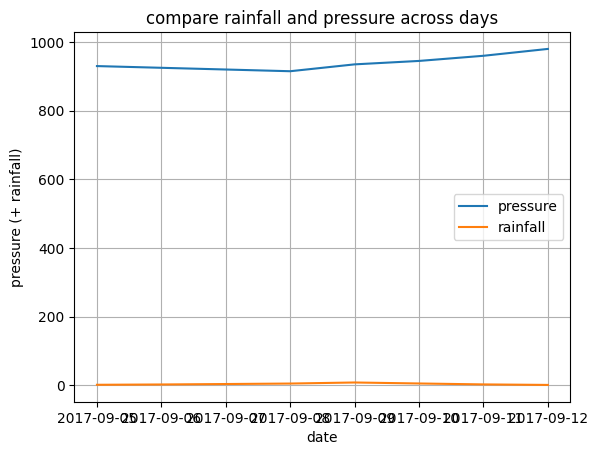

In [5]:
queries = [
    "show wind speed trend over time",
    "compare rainfall and pressure across days",
]

for q in queries:
    print(f"\nQuery: {q}")
    try:
        spec = nl_to_plot_spec(q)
        print("Spec:", spec)
        generate_plot(df, spec)
    except Exception as e:
        print("Error:", e)



## Notes on Correctness & Usability

**Correctness**
- The mapper only allows known columns (`wind_speed`, `pressure`, `rainfall`, `storm_category`) and `date` for x-axis.
- Ambiguous queries are rejected with a helpful message.
- The dataset is illustrative but aligned with Irma’s timeline near Florida landfall (2017-09-10).

**Usability**
- Queries with keywords like "wind", "rain", "pressure", "category", "compare", "bar", "scatter" are supported.
- The derived spec is printed before plotting for transparency.
- Matplotlib-only plots ensure compatibility (no seaborn/styles).

**Limitations / Future Work**
- Extend synonyms and add a lightweight LLM-based fallback for more flexible phrasing.
- Support multiple x-axes or resampling for sub-daily data.



### (Optional) Save the dataset used in this notebook


In [6]:
df.to_csv("florida_irma_embedded.csv", index=False)
print("Saved to florida_irma_embedded.csv")


Saved to florida_irma_embedded.csv
